In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = os.path.join(os.getcwd(), 'data/vkyn01-dataset')

In [3]:
print(PATH)

C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset


In [4]:
train_dir = os.path.join(PATH, 'train')
print(train_dir)
validation_dir = os.path.join(PATH, 'val')
print(validation_dir)

C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset\train
C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset\val


In [24]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

In [25]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 16605 files belonging to 2 classes.


In [26]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4158 files belonging to 2 classes.


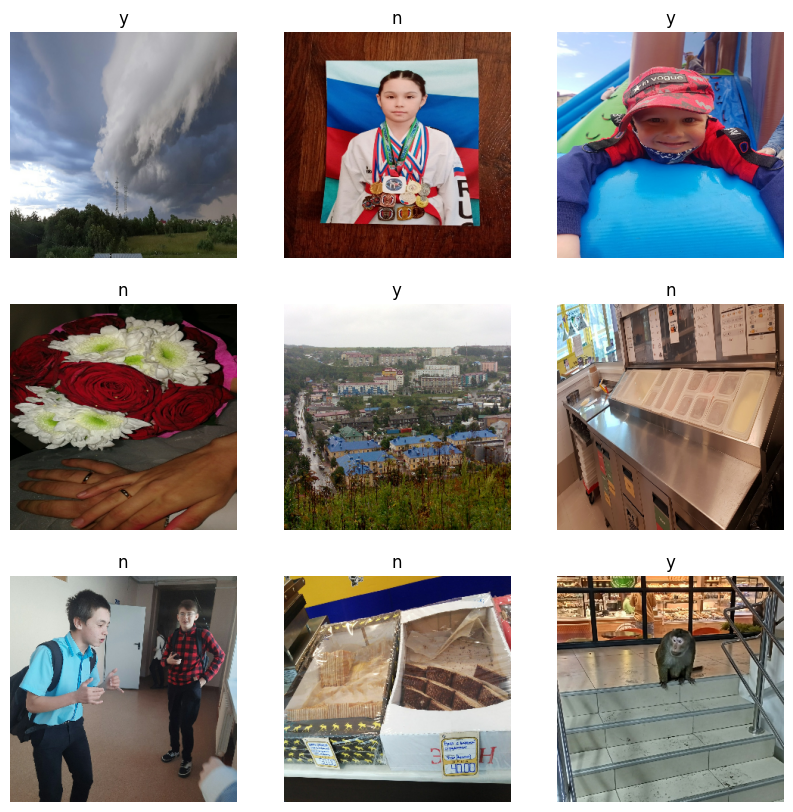

In [27]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [29]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 104
Number of test batches: 26


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [31]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

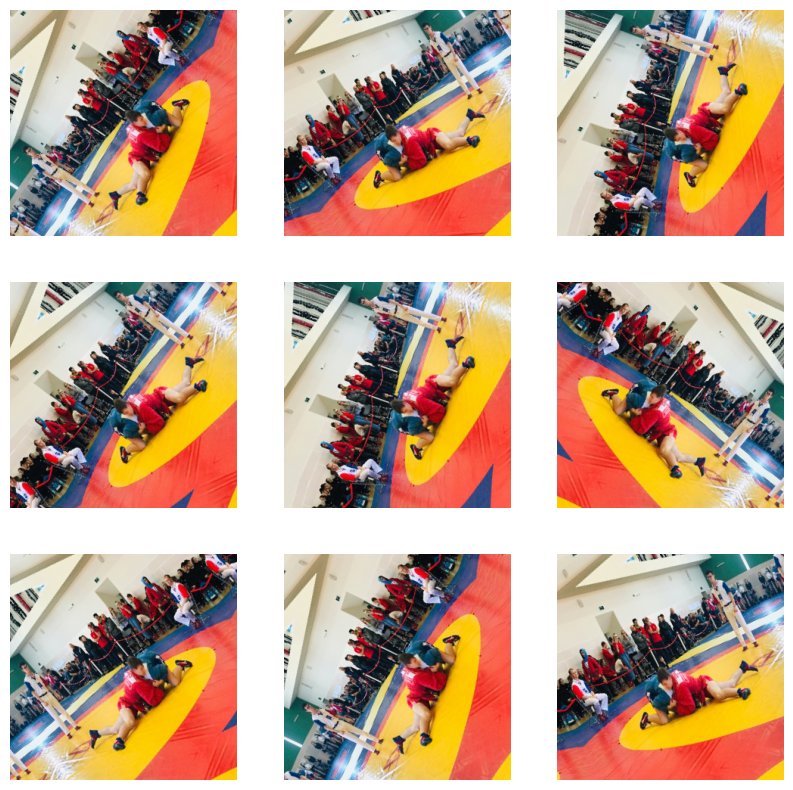

In [32]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [33]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [34]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [35]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [37]:
base_model.trainable = False

In [ ]:
#base_model.summary()

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

ValueError: Input 0 of layer "global_average_pooling2d_2" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (32, 1000)

In [39]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

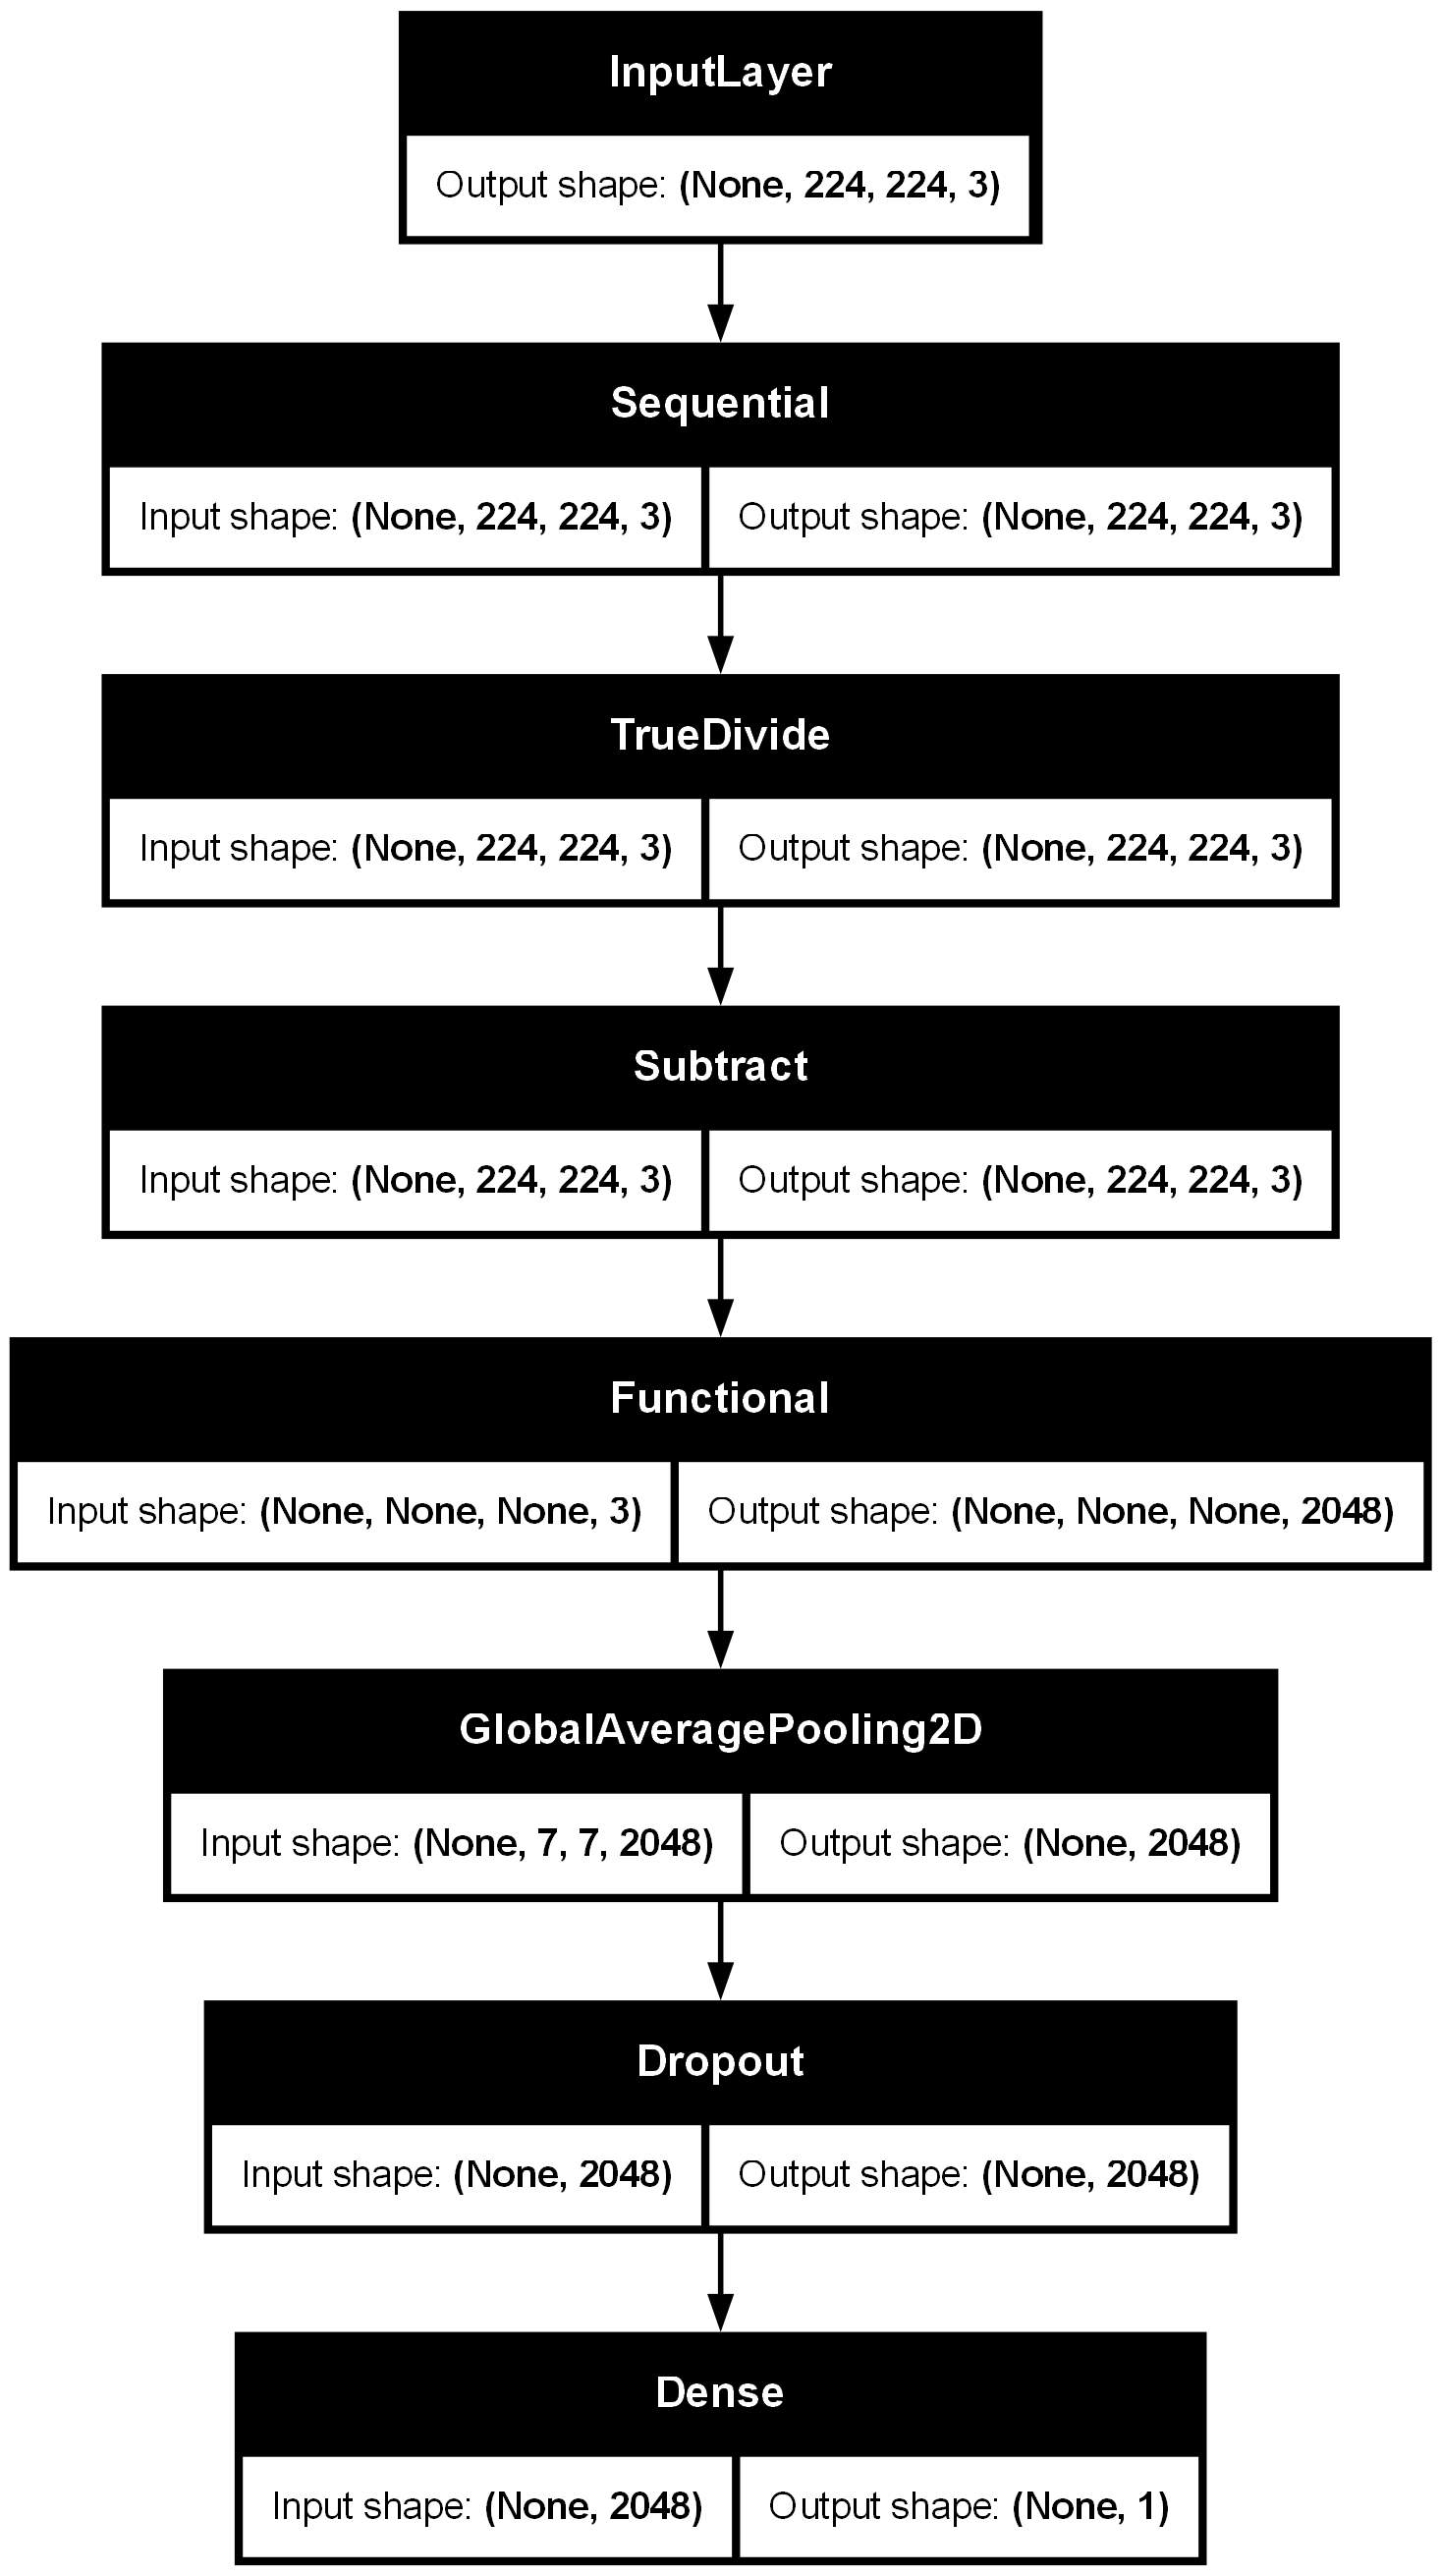

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.5541 - loss: 0.6881


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.56


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 221s 420ms/step - accuracy: 0.5475 - loss: 0.6995 - val_accuracy: 0.6046 - val_loss: 0.6615
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 217s 419ms/step - accuracy: 0.5813 - loss: 0.6749 - val_accuracy: 0.6146 - val_loss: 0.6505
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 217s 419ms/step - accuracy: 0.6046 - loss: 0.6578 - val_accuracy: 0.6242 - val_loss: 0.6442
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 221s 425ms/step - accuracy: 0.6197 - loss: 0.6488 - val_accuracy: 0.6305 - val_loss: 0.6377
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 217s 417ms/step - accuracy: 0.6258 - loss: 0.6438 - val_accuracy: 0.6353 - val_loss: 0.6334
Epoch 6/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 216s 416ms/step - accuracy: 0.6356 - loss: 0.6367 - val_accuracy: 0.6422 - val_loss: 0.6291
Epoch 7/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 217s 419ms/step - accuracy: 0.6418 - loss: 0.6324 - val_accuracy: 0.6398 - val_loss: 0.6262
Epoch 8/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 220s 424ms/step - accuracy: 0.6504 -

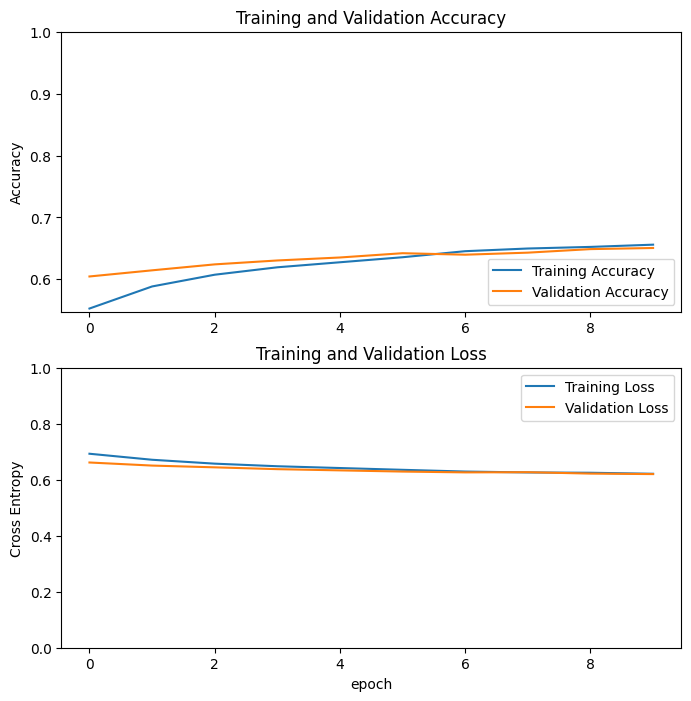

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])